In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from keras.regularizers import l2
import warnings
import pprint
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"D:\DS\Datasets\Aep_hourly\AEP_hourly.csv")

In [3]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [4]:
df.tail()

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [5]:
df.shape

(121273, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [7]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [8]:
df.isna().sum()

Datetime    0
AEP_MW      0
dtype: int64

In [9]:
df.duplicated().sum()

0

### Reformating the date column

In [11]:
df.dtypes

Datetime     object
AEP_MW      float64
dtype: object

In [12]:
dataset = df.copy()

In [13]:
dataset.dtypes

Datetime     object
AEP_MW      float64
dtype: object

In [28]:
# Extract all Data Like Year MOnth Day Time etc
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["Datetime"]).dt.time
dataset["Week"]= pd.to_datetime(df["Datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()
dataset = df.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)
dataset.head(1)

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0


In [30]:
dataset.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [16]:
dataset = dataset.set_index("Datetime")

In [40]:
dataset.dtypes

AEP_MW    float64
dtype: object

In [46]:
def find_outliers(dataset, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    condition = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers = df[condition]
    
    return outliers

In [48]:
AEP_outliers = find_outliers(dataset, 'AEP_MW')
AEP_outliers

,Datetime,AEP_MW
272,2004-12-20 09:00:00,22577.0
2478,2005-12-20 08:00:00,22573.0
5603,2005-08-12 14:00:00,22909.0
5604,2005-08-12 15:00:00,23371.0
5605,2005-08-12 16:00:00,23243.0
...,...,...
120848,2018-01-18 08:00:00,22567.0
121208,2018-01-03 08:00:00,22759.0
121209,2018-01-03 09:00:00,22624.0
121232,2018-01-02 08:00:00,22685.0


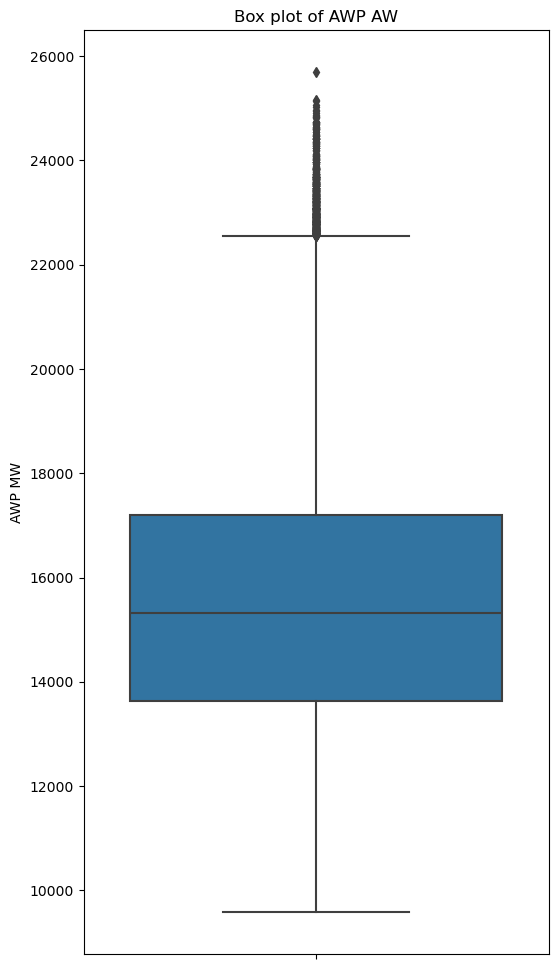

In [50]:
# Box plot of Average Daily Rate
plt.figure(figsize=(6, 12))
sns.boxplot(y=dataset['AEP_MW'])
plt.title('Box plot of AWP AW')
plt.ylabel('AWP MW')
plt.show()

In [52]:
def remove_outliers(dataset, col):
    q1 = dataset[col].quantile(0.25)
    q3 = dataset[col].quantile(0.75)

    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    # Condition for filtering out outliers
    condition = (dataset[col] >= lower_bound) & (dataset[col] <= upper_bound)
    
    # Removing outliers
    cleaned_dataset = dataset[condition]

    return cleaned_dataset

In [54]:
cleaned_df = remove_outliers(df, 'AEP_MW')

In [56]:
cleaned_df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


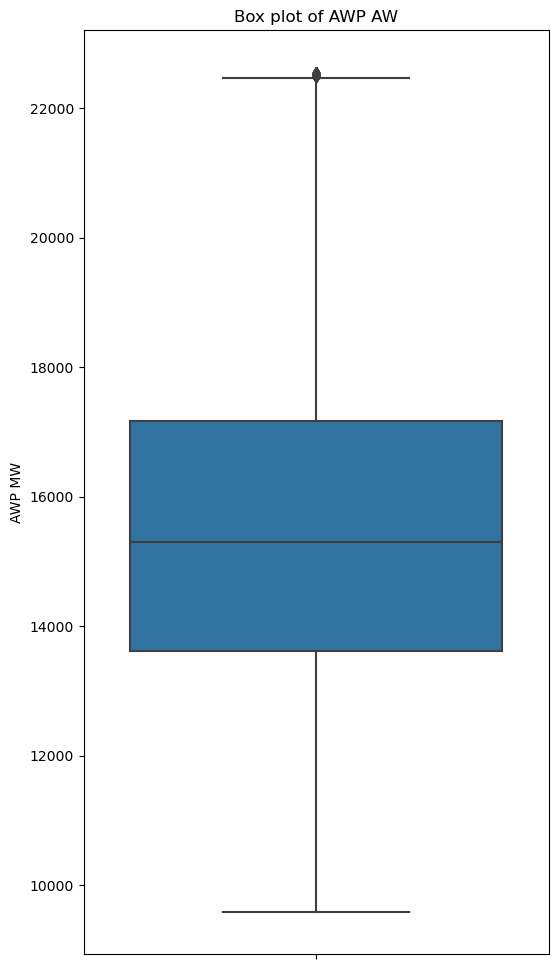

In [58]:
# Box plot of Average Daily Rate
plt.figure(figsize=(6, 12))
sns.boxplot(y=cleaned_df['AEP_MW'])
plt.title('Box plot of AWP AW')
plt.ylabel('AWP MW')
plt.show()

In [60]:
cleaned_df["Month"]= pd.to_datetime(cleaned_df["Datetime"]).dt.month
cleaned_df["Year"]= pd.to_datetime(cleaned_df["Datetime"]).dt.year
cleaned_df["Date"]= pd.to_datetime(cleaned_df["Datetime"]).dt.date
cleaned_df["Time"]= pd.to_datetime(cleaned_df["Datetime"]).dt.time
cleaned_df["Week"]= pd.to_datetime(cleaned_df["Datetime"]).dt.isocalendar().week
cleaned_df["Day"] = pd.to_datetime(cleaned_df["Datetime"]).dt.day_name()

In [61]:
cleaned_df.head()

,Datetime,AEP_MW,Month,Year,Date,Time,Week,Day
0,2004-12-31 01:00:00,13478.0,12,2004,2004-12-31,01:00:00,53,Friday
1,2004-12-31 02:00:00,12865.0,12,2004,2004-12-31,02:00:00,53,Friday
2,2004-12-31 03:00:00,12577.0,12,2004,2004-12-31,03:00:00,53,Friday
3,2004-12-31 04:00:00,12517.0,12,2004,2004-12-31,04:00:00,53,Friday
4,2004-12-31 05:00:00,12670.0,12,2004,2004-12-31,05:00:00,53,Friday


### Energy With Respect to Dates

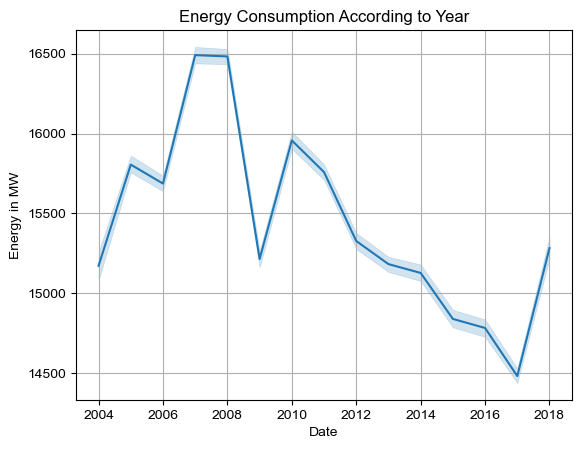

In [65]:
from matplotlib import style

fig = plt.figure()
ax1 = plt.subplot2grid((1,1),(0,0))

style.use('ggplot')

sns.lineplot (x=cleaned_df["Year"], y=cleaned_df["AEP_MW"])
sns.set(rc = {'figure.figsize' :(15,6)})

# plt.title("Energy consumption in Year 2015")
plt.title("Energy Consumption According to Year")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True)
plt.show()
# plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

# plot.title("Energy Consumption According to Year")

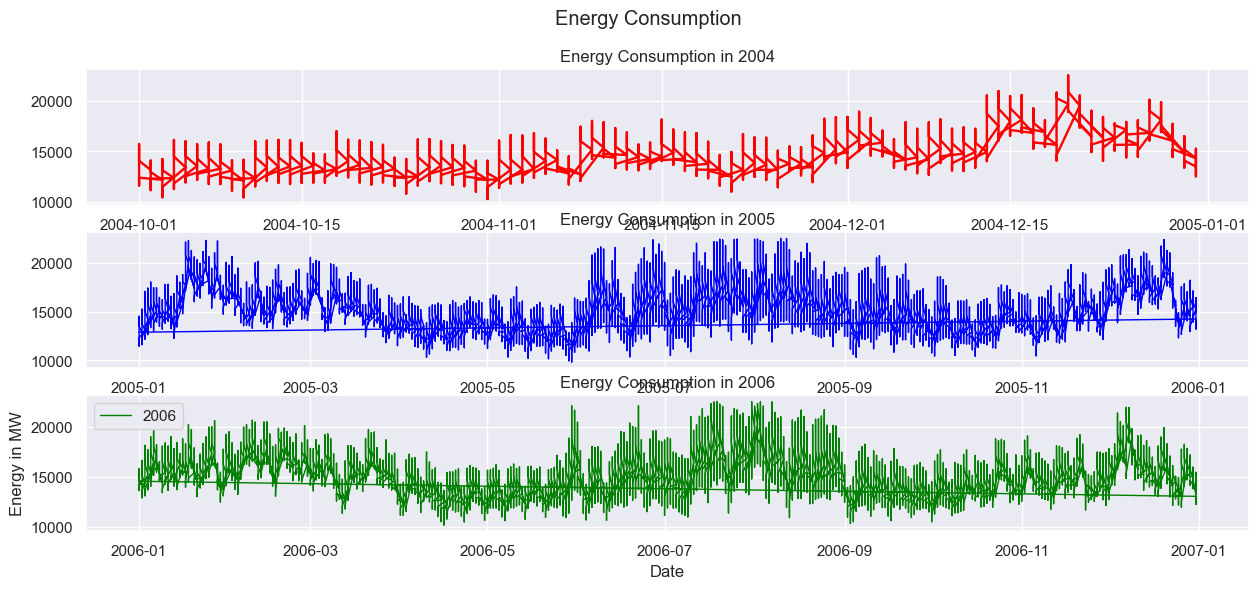

In [66]:
# Assuming 'dataset' is already defined and contains a 'Date' column
# Ensure 'Date' is in datetime format
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])

# Set 'Date' as the index
cleaned_df.set_index('Date', inplace=True)

# Create the figure and subplots
fig = plt.figure()
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

# Optional: Use a specific style
# plt.style.use('ggplot')

# Plot for 2004
y_2004 = cleaned_df.loc['2004']['AEP_MW'].to_list()
x_2004 = cleaned_df.loc['2004'].index.to_list()  # Use index for x-axis
ax1.plot(x_2004, y_2004, color="red", linewidth=1.7, label="2004")

# Plot for 2005
y_2005 = cleaned_df.loc['2005']['AEP_MW'].to_list()
x_2005 = cleaned_df.loc['2005'].index.to_list()  # Use index for x-axis
ax2.plot(x_2005, y_2005, color="blue", linewidth=1, label="2005")

# Plot for 2006
y_2006 = cleaned_df.loc['2006']['AEP_MW'].to_list()
x_2006 = cleaned_df.loc['2006'].index.to_list()  # Use index for x-axis
ax3.plot(x_2006, y_2006, color="green", linewidth=1, label="2006")

# Set figure size
plt.rcParams["figure.figsize"] = (30, 20)  # Set a valid height

# Set titles and labels
plt.suptitle("Energy Consumption")
ax1.set_title("Energy Consumption in 2004")
ax2.set_title("Energy Consumption in 2005")
ax3.set_title("Energy Consumption in 2006")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True, alpha=1)
plt.legend()
plt.show()

### Energy Distribution

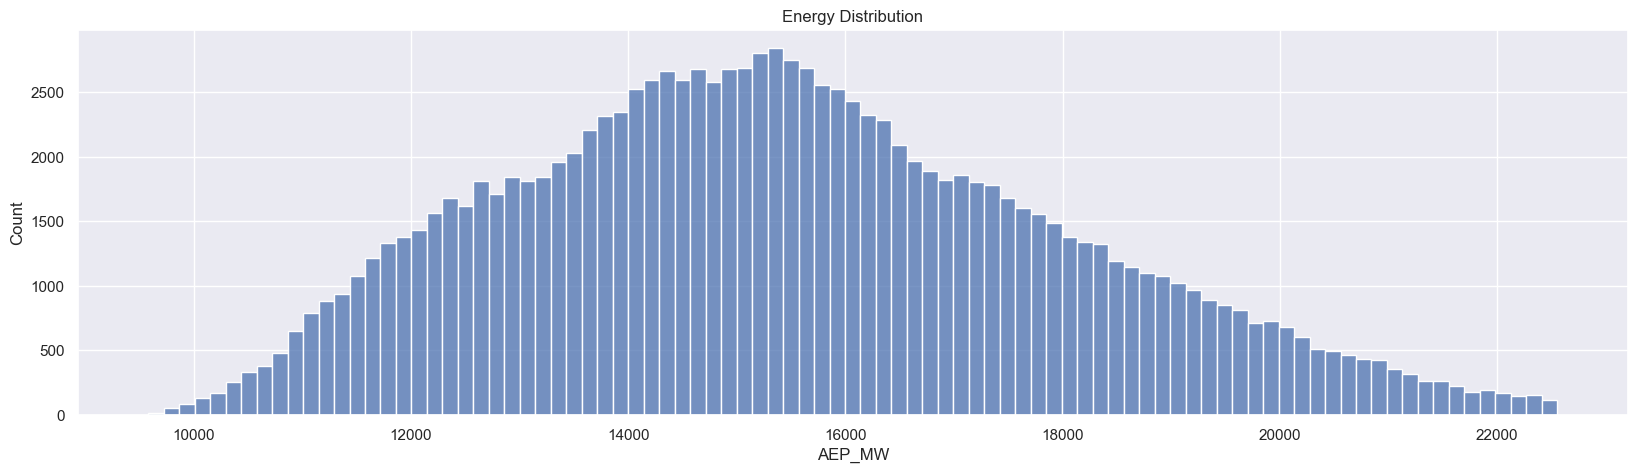

In [69]:
plt.figure(figsize = (20,5))

sns.histplot(cleaned_df["AEP_MW"])

plt.title("Energy Distribution")
plt.show()

### Energy with Respect to Time

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, '01:00:00'),
  Text(1, 0, '02:00:00'),
  Text(2, 0, '03:00:00'),
  Text(3, 0, '04:00:00'),
  Text(4, 0, '05:00:00'),
  Text(5, 0, '06:00:00'),
  Text(6, 0, '07:00:00'),
  Text(7, 0, '08:00:00'),
  Text(8, 0, '09:00:00'),
  Text(9, 0, '10:00:00'),
  Text(10, 0, '11:00:00'),
  Text(11, 0, '12:00:00'),
  Text(12, 0, '13:00:00'),
  Text(13, 0, '14:00:00'),
  Text(14, 0, '15:00:00'),
  Text(15, 0, '16:00:00'),
  Text(16, 0, '17:00:00'),
  Text(17, 0, '18:00:00'),
  Text(18, 0, '19:00:00'),
  Text(19, 0, '20:00:00'),
  Text(20, 0, '21:00:00'),
  Text(21, 0, '22:00:00'),
  Text(22, 0, '23:00:00'),
  Text(23, 0, '00:00:00')])

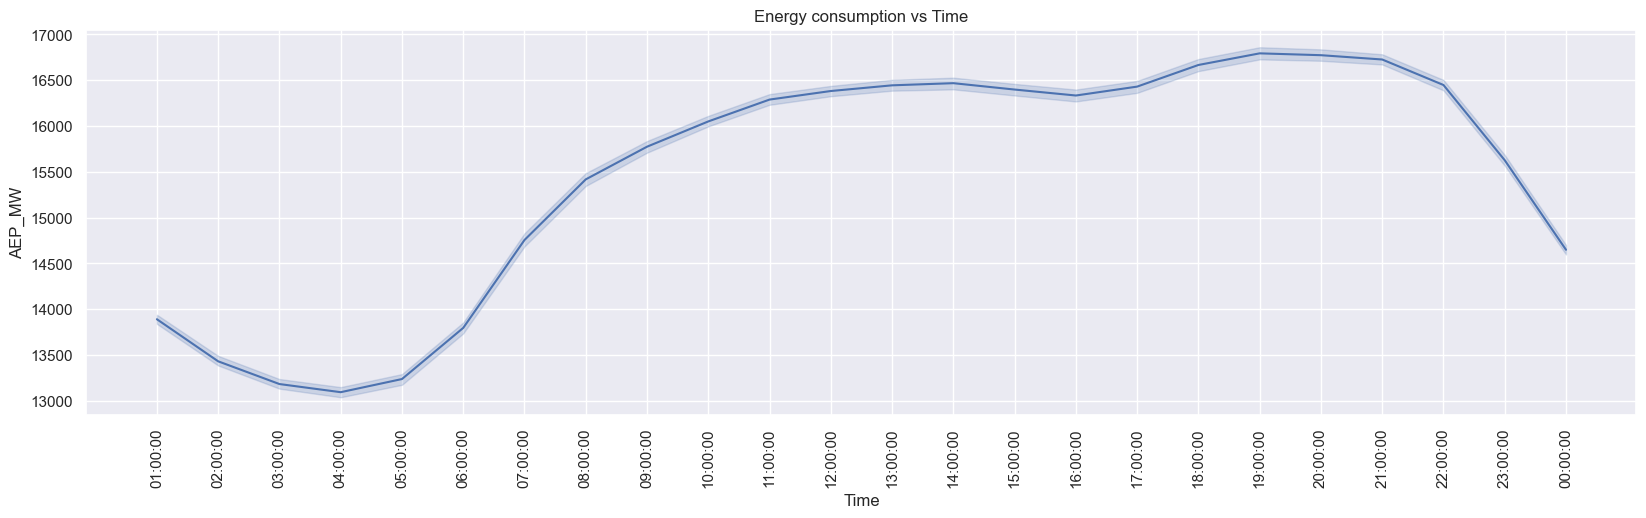

In [73]:
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(1,1,1)

datatime  = cleaned_df["Time"].astype(str)
sns.lineplot(x = datatime, y=cleaned_df["AEP_MW"],data = cleaned_df)
plt.title("Energy consumption vs Time")
plt.xlabel("Time")
plt.grid(True, alpha = 1)
plt.xticks(rotation=90)

In [80]:
cleaned_df.dtypes

Datetime     object
AEP_MW      float64
Month         int32
Year          int32
Time         object
Week         UInt32
Day          object
dtype: object

### Resampling the Data

In [38]:
cleaned_df.head(1)

,Datetime,AEP_MW,Month,Year,Time,Week,Day
Date,,,,,,,
2004-12-31,2004-12-31 01:00:00,13478.0,12,2004,01:00:00,53,Friday


In [39]:
cleaned_df.dtypes

Datetime     object
AEP_MW      float64
Month         int32
Year          int32
Time         object
Week         UInt32
Day          object
dtype: object

In [82]:
sc = MinMaxScaler()
# Normalize the extracted features
normalized_features = sc.fit_transform(cleaned_df[['Year', 'Month', 'Week','AEP_MW']])

# Create a new DataFrame with normalized features
normalized_df = pd.DataFrame(normalized_features, columns=['Year', 'Month', 'Week','AEP_MW'])

In [84]:
cleaned_df.describe()

,AEP_MW,Month,Year,Week
count,120606.000000,120606.000000,120606.000000,120606.0
mean,15456.672578,6.503781,2011.182155,26.51296
std,2533.155917,3.463553,4.013221,15.140837
min,9581.000000,1.000000,2004.000000,1.0
25%,13620.000000,4.000000,2008.000000,13.0
50%,15292.000000,6.000000,2011.000000,26.0
75%,17161.000000,10.000000,2015.000000,40.0
max,22554.000000,12.000000,2018.000000,53.0


In [86]:
normalized_df.describe()

,Year,Month,Week,AEP_MW
count,120606.000000,120606.000000,120606.000000,120606.000000
mean,0.513011,0.500344,0.490634,0.452915
std,0.286659,0.314868,0.291170,0.195264
min,0.000000,0.000000,0.000000,0.000000
25%,0.285714,0.272727,0.230769,0.311339
50%,0.500000,0.454545,0.480769,0.440222
75%,0.785714,0.818182,0.750000,0.584290
max,1.000000,1.000000,1.000000,1.000000


split_index = int(len(normalized_df) * 0.8)
train_data = normalized_df[:split_index]  # First 80% for training
test_data = normalized_df[split_index:]

train_data = train_data.values

In [99]:
TestData = normalized_df.tail(100)

Training_Set = normalized_df.iloc[:,0:1]

Training_set = Training_Set[:-60]

In [101]:
print(Training_Set.shape)
print(TestData.shape)

(120606, 1)
(100, 4)


In [103]:
Training_Set = Training_Set.values
sc = MinMaxScaler(feature_range=(0,1))
Train = sc.fit_transform(Training_Set)

In [106]:

X_Train = []
Y_Train = []

# Range should be fromm 60 Values to END 
for i in range(60, Train.shape[0]):
    
    # X_Train 0-59 
    X_Train.append(Train[i-60:i])
    
    # Y Would be 60 th Value based on past 60 Values 
    Y_Train.append(Train[i])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)


# # Prepare the training data
# X_train = []
# y_train = []

# sequence_length = 60
# if len(train_data) < sequence_length:
#     raise ValueError(f"Training data has only {len(train_data)} rows, but sequence length is {sequence_length}.")

# # Create sequences for LSTM
# for i in range(sequence_length, len(train_data)):
#     X_train.append(train_data[i-sequence_length:i])  # Previous 60 values
#     y_train.append(train_data[i, 0])                 # Current value

# # Convert to numpy arrays
# X_train, y_train = np.array(X_train), np.array(y_train)

# # Debugging: Check the shapes
# print("Shape of X_train before reshaping:", X_train.shape)
# print("Shape of y_train:", y_train.shape)

(120546, 60, 1)
(120546, 1)


# Extract the first feature (column) from X_train
X_train = X_train[:, :, 0]  # Shape: (96958, 60)

# Reshape to (96958, 60, 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) 
print(X_train.shape)

In [109]:
# Shape should be Number of [Datapoints , Steps , 1 )
# we convert into 3-d Vector or #rd Dimesnsion
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))
X_Train.shape

(120546, 60, 1)

In [111]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
regressor.fit(X_Train, Y_Train, epochs = 50, batch_size = 32)
# regressor.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 329s 85ms/step - loss: 0.0052
Epoch 2/50
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 323s 86ms/step - loss: 8.0577e-04
Epoch 3/50
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 327s 87ms/step - loss: 6.3876e-04
Epoch 4/50
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 362s 96ms/step - loss: 6.0716e-04
Epoch 5/50
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 517s 137ms/step - loss: 5.6455e-04
Epoch 6/50
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 503s 134ms/step - loss: 5.5481e-04
Epoch 7/50
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 356s 94ms/step - loss: 5.4766e-04
Epoch 8/50
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 358s 95ms/step - loss: 5.3851e-04
Epoch 9/50
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 384s 102ms/step - loss: 5.3070e-04
Epoch 10/50
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 434s 115ms/step - loss: 5.2844e-04
Epoch 11/50
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 387s 103ms/step - loss: 5.2811e-04
Epoch 12/50
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 380s 101ms/step - loss: 5.1037e-04
Epoch 13/50
3768/3768 ━━━━━━━━━━━━━━━━━━━━ 346s 92ms/step - loss: 4.9978e-04
Epoch 

### Test Data

In [105]:
test_data.head(2)

,Year,Month,Week,AEP_MW
96484,0.785714,0.181818,0.173077,0.668388
96485,0.785714,0.181818,0.173077,0.650119


In [107]:
test_data.shape

(24122, 4)

In [109]:
# NewDataset.shape

In [113]:
DF_Total = pd.concat((normalized_df[["AEP_MW"]], test_data[["AEP_MW"]]),axis =0)

In [115]:
DF_Total.shape

(144728, 1)

In [135]:
# Extract the last 60 + len(test_data) rows from DF_Total
inputs = DF_Total[len(DF_Total) - len(test_data) - 60:].values

# Ensure inputs has the correct shape (n_samples, n_features)
print("Shape of inputs:", inputs.shape)  # Debugging
inputs = inputs.reshape(-1, 5)  # Ensure this matches the number of features used in training

# Normalize the dataset using the fitted scaler
inputs = sc.transform(inputs)

# Prepare the X_test dataset
X_test = []
for i in range(60, len(inputs)):  # Adjusted to use the length of inputs
    X_test.append(inputs[i-60:i])

# Convert into Numpy Array
X_test = np.array(X_test)
print("Shape of X_test:", X_test.shape)  # Debugging

# Reshape before passing to the network (LSTM expects 3D input)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))  # 5 is the number of features

# Pass to Model
predicted_mw = regressor.predict(X_test)

# Do inverse transformation to get original values
predicted_mw = sc.inverse_transform(predicted_mw)

Shape of inputs: (24182, 1)


ValueError: cannot reshape array of size 24182 into shape (5)

In [121]:
True_Megawatt = test_data["AEP_MW"].to_list()
Predicted_Megawatt = predicted_mw
dates = test_data.index.to_list()

NameError: name 'predicted_mw' is not defined

In [ ]:
Machine_DF = pd.DataFrame(data =
                          {'Date':dates,'TrueMegaWatt':True_Megawatt,
'PredictedMegaWatt':[x[0] for x in Predicted_Megawatt]})

### Future Predicted

In [ ]:
Machine_DF

In [ ]:
True_Megawatt = test_data["AEP_MW"].to_list()
Predicted_Megawatt = [x[0] for x in Predicted_Megawatt]
dates =test_data.index.to_list()

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(111)

x = dates
y=True_Megawatt

y1 = Predicted_Megawatt

plt.plot(x,y, color = 'green')
plt.plot(x,y1, color = 'red')

plt.gcf().autofmt_xdate()
plt.xlabel('Dates')
plt.ylabel('Power in MW')
plt.title ("Machine Learned the Pattern Predicting Future Values")
plt.show